# Determination of Short Tail Keywords for Marketing - Case Study:

In [3]:
import pandas as pd
import numpy as np
import itertools 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score
from scipy.spatial.distance import cdist, pdist

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.grid'] = False

In [7]:
df = pd.read_csv('/content/[UCI] AAAI-14 Accepted Papers - Papers.csv')
print(f'Dimension of Data: {df.shape}')
for col in df.columns:
    print(f'Column: {col:10} |\
    Type: {str(df[col].dtype):10} |\
    Missing Values: {df[col].isnull().sum()}')

Dimension of Data: (398, 6)
Column: title      |    Type: object     |    Missing Values: 0
Column: authors    |    Type: object     |    Missing Values: 0
Column: groups     |    Type: object     |    Missing Values: 2
Column: keywords   |    Type: object     |    Missing Values: 0
Column: topics     |    Type: object     |    Missing Values: 4
Column: abstract   |    Type: object     |    Missing Values: 0


In [8]:
df.head()

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."


In [9]:
df_train = df[['title','groups','keywords','topics']]
print(len(df_train))

398


In [10]:
df_train.head()

,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...


## Data Transformation for Modelling:

In [16]:
import operator
s = df['groups'].str.split('\n').apply(
    pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del df_train['groups']
df_train = df_train.join(s).reset_index()

In [17]:
df_train['flags'] = pd.Series(
    np.ones(len(df_train)
), index=df_train.index)
df_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


In [25]:
def matrix_df(df_train):
    matrix = df_train.pivot_table(
        index=['title'], columns=['groups'],
        values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix,x_cols

In [26]:
matrix, x_cols = matrix_df(df_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),Humans and AI (HAI),Knowledge Representation and Reasoning (KRR),Machine Learning Applications (MLA),Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering Model - K-Means:

### Elbow Method:

In [28]:
X = matrix[x_cols]
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]
avgwithinSS = [sum(d) / X.shape[0] for d in dist]

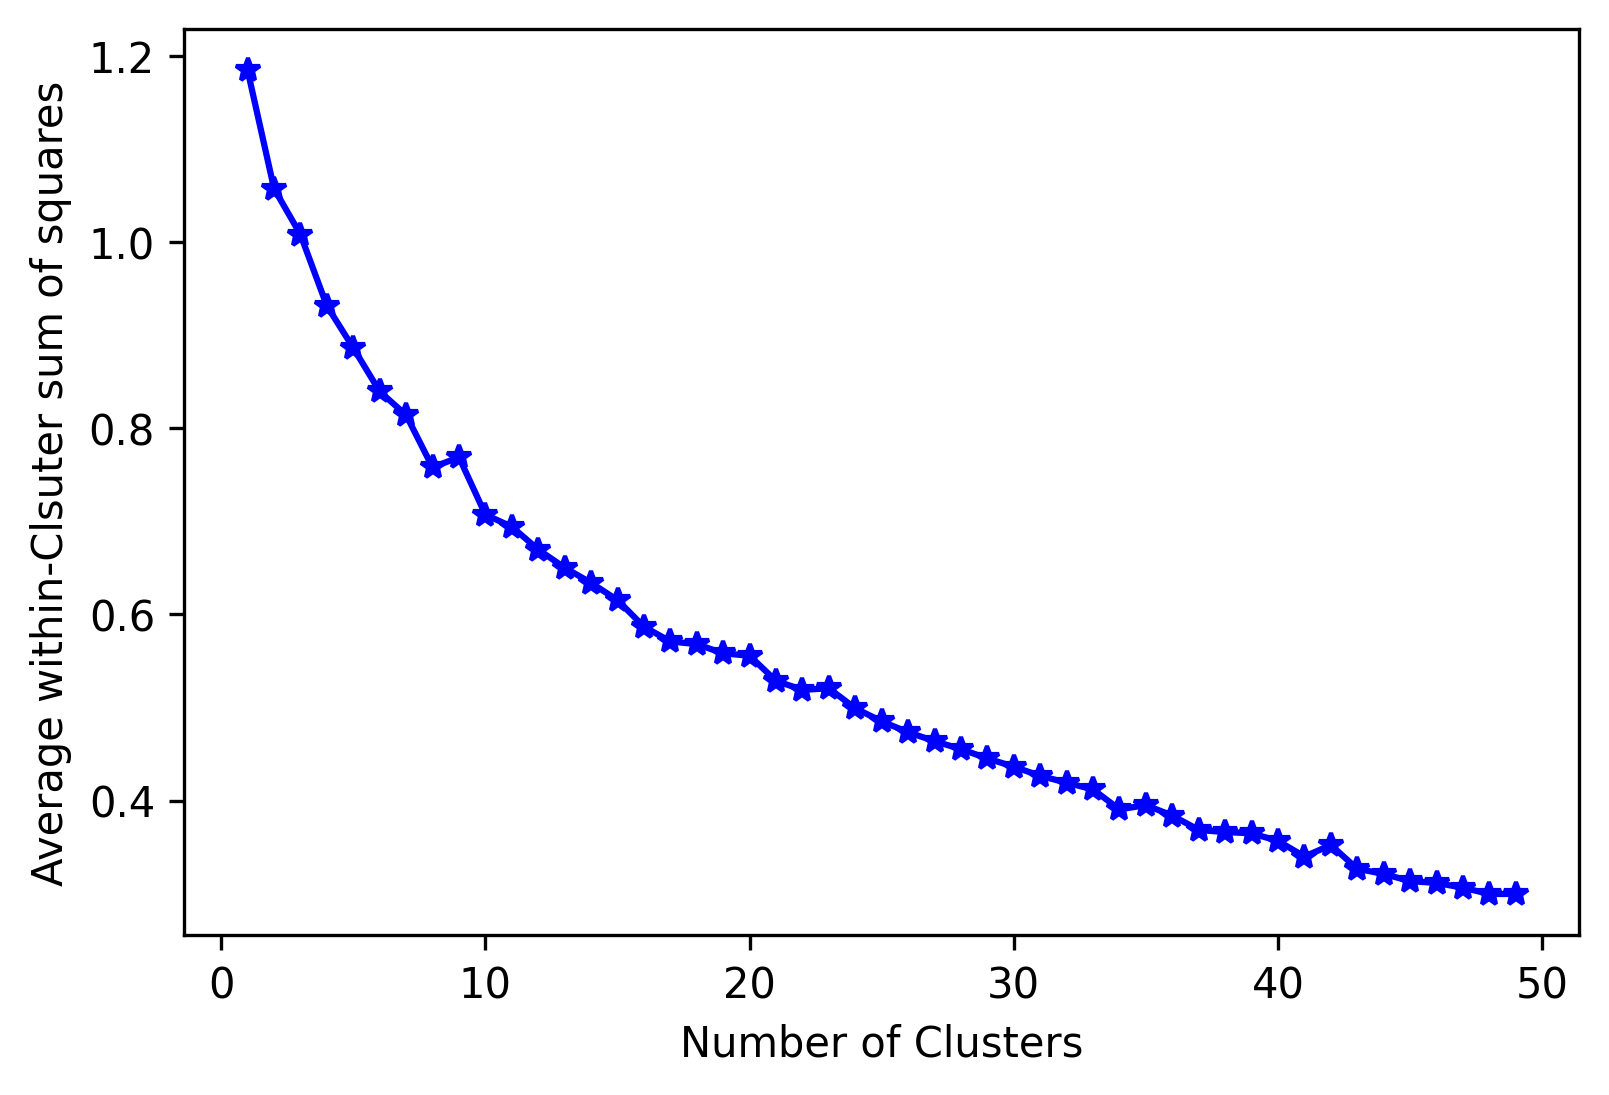

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgwithinSS, 'b*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-Clsuter sum of squares')
plt.show()

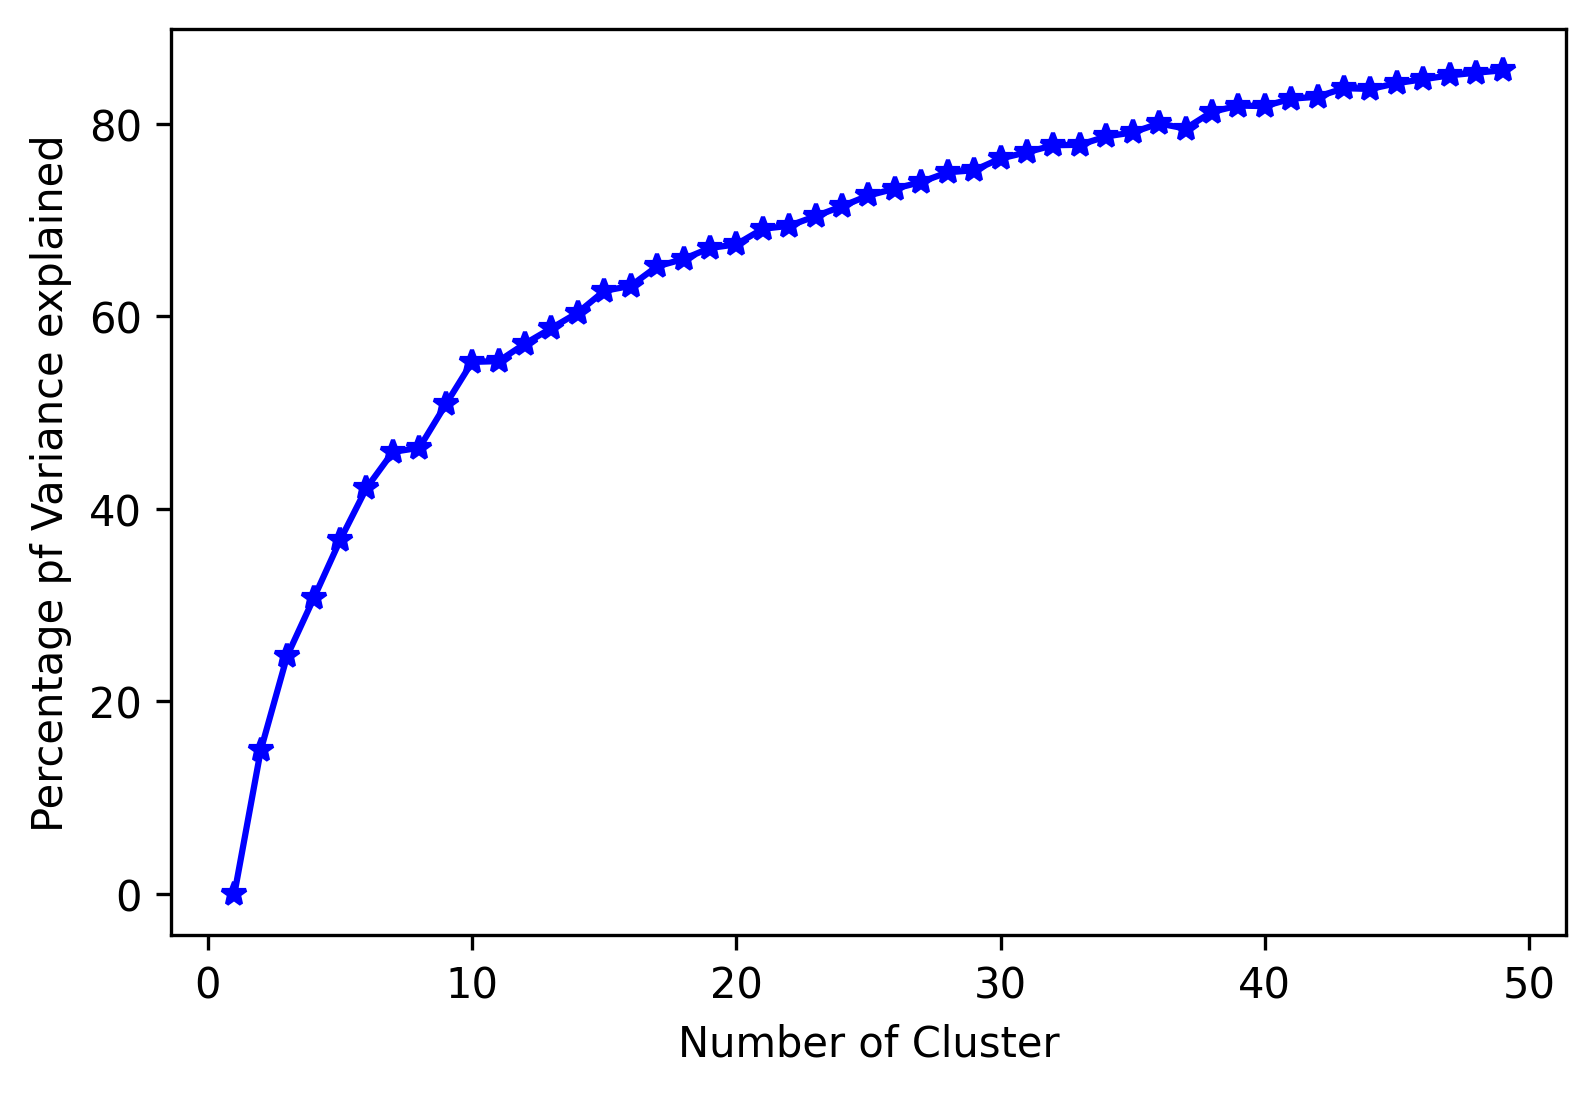

In [33]:
matrix, x_cols = matrix_df(df_train)
X = matrix[x_cols]
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X,cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]

wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/ X.shape[0]
bss = tss-wcss

kIDX = 10-1

fig= plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.xlabel('Number of Cluster')
plt.ylabel('Percentage pf Variance explained')
plt.show()

### Silhouette Score:

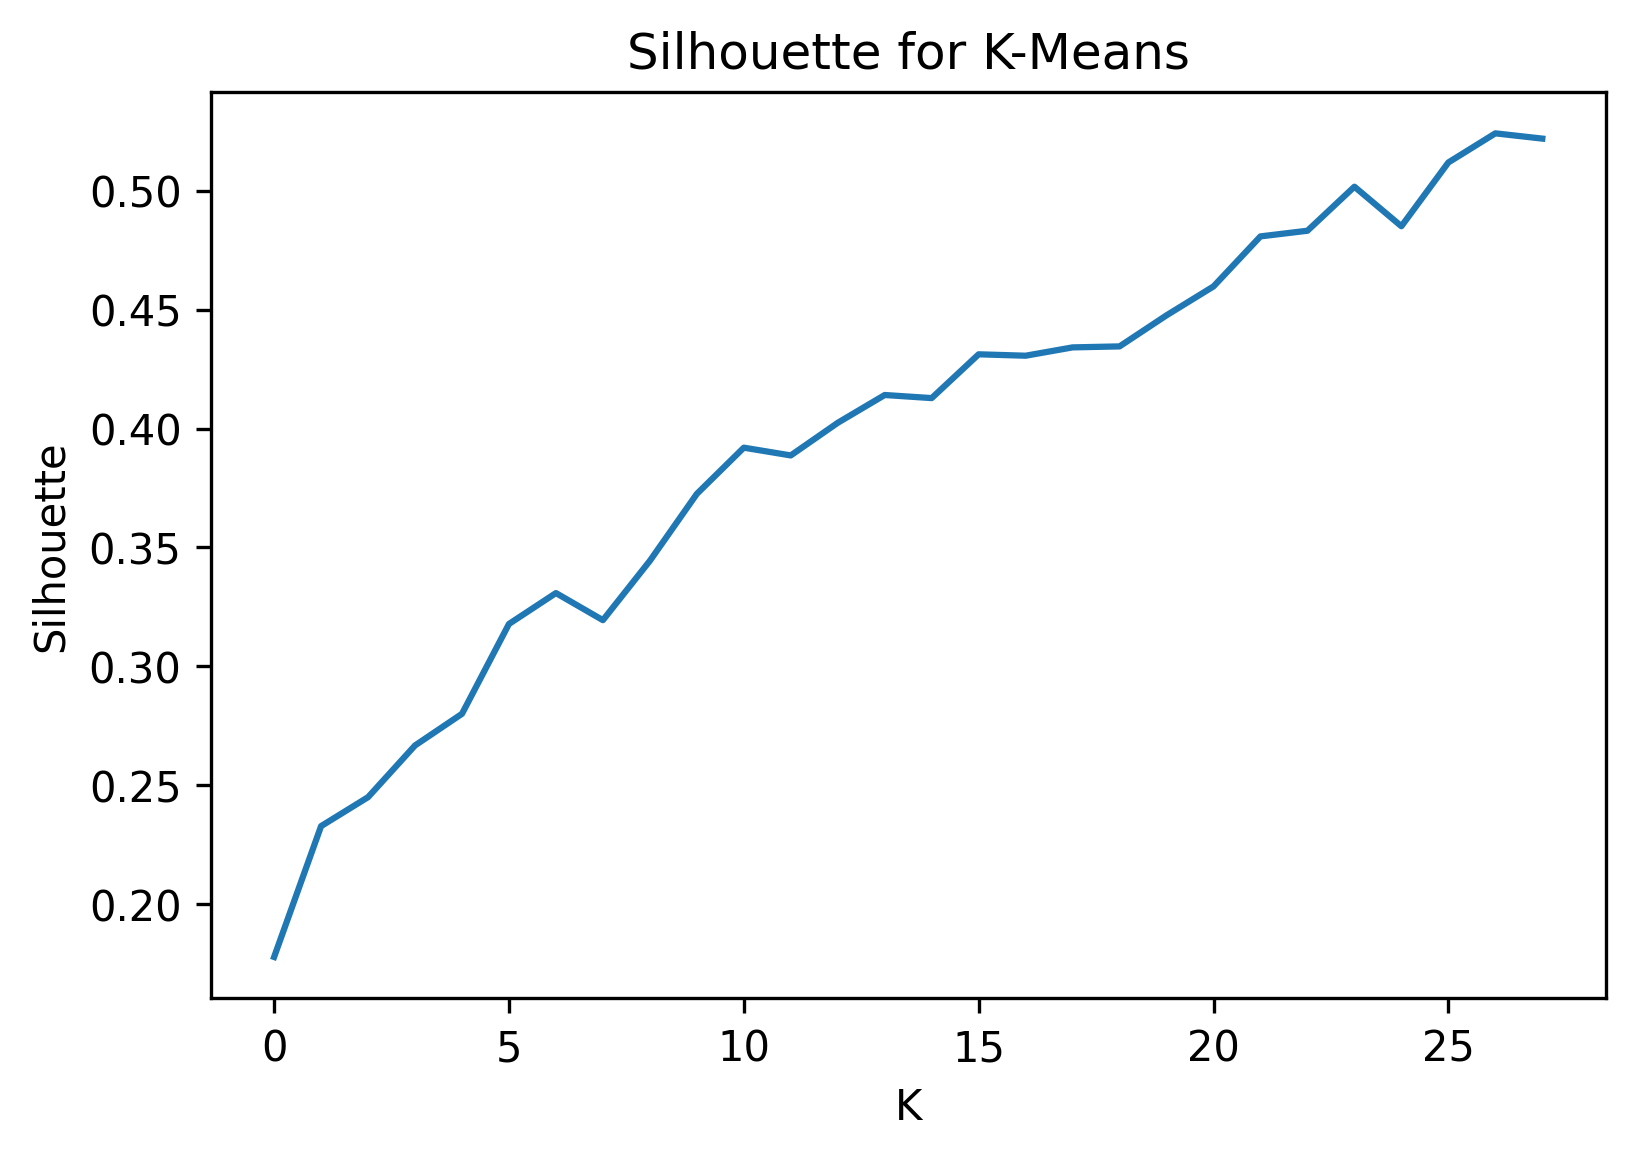

In [34]:
s = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(X, labels, 
        metric='euclidean'))
    
plt.plot(s)
plt.ylabel('Silhouette')
plt.xlabel('K')
plt.title('Silhouette for K-Means')
plt.show()

### Applying K-Means clustering for Optimal Number of CLusters:

In [46]:
matrix, X_cols = matrix_df(df_train)
X = matrix[x_cols]
cluster = KMeans(n_clusters=9, random_state=21)
matrix['cluster'] = cluster.fit_predict(X)
matrix['cluster'].value_counts()

1    78
2    64
0    64
6    39
7    35
3    31
8    31
5    29
4    25
Name: cluster, dtype: int64

## Dimensionality Reduction - Principle Component Analysis:

In [48]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(
    matrix[x_cols]
)[:,0]
matrix['y'] = pca.fit_transform(
    matrix[X_cols]
)[:,1]

customer_clusters = matrix[['title','cluster','x','y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",1,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,3,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",4,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,8,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,6,0.198578,-0.129668


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


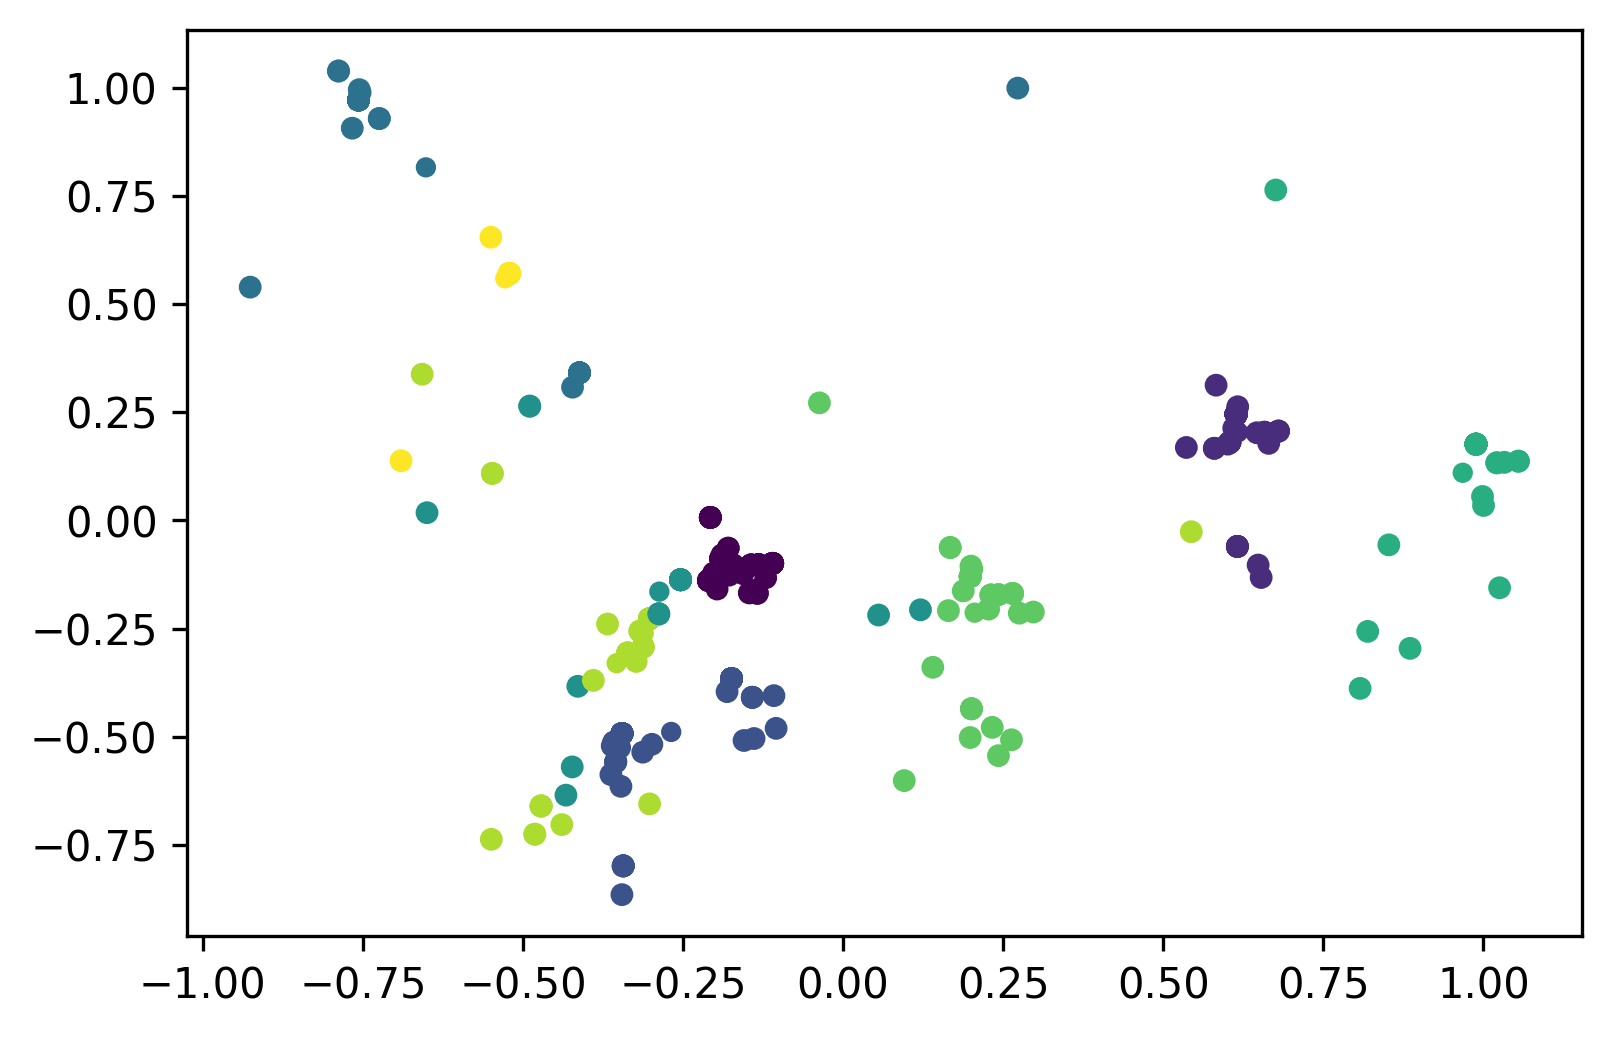

In [49]:
cluster_centers = pca.transform(
    cluster.cluster_centers_)
cluster_centers = pd.DataFrame(
    cluster_centers, columns=['x','y'])
cluster_centers['cluster'] = range(
    0, len(cluster_centers)
)
plt.scatter(customer_clusters['x'],
            customer_clusters['y'], s=20,
            c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'],
            cluster_centers['y'],s=15,
            c=cluster_centers['cluster'])
plt.show()

In [52]:
customer_clusters.columns.name = None
data = df_train.merge(customer_clusters, on='title')
data.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,1,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,8,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


### Methods to find Complete Keywords for Given Clusters:

In [61]:
def perform_cluster_group_audit(clusters, term): 
    for cluster in clusters: 
        df_cluster = data[data['cluster'] == cluster] 
        print ('Cluster number: %d'%(cluster + 1))
        keywords = list(df_cluster['keywords']) 
        keywords = [keyword.split('\n') for keyword in keywords] 
        keywords = [item for sublist in keywords for item in sublist] 
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords} 
        print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True)) 
        print('\n')

In [62]:
perform_cluster_group_audit([0,4], 'search')

Cluster number: 1
[('similarity search', 1), ('approximate nearest neighbor search', 1), ('heuristic search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('bounded suboptimal search', 1), ('best-first search', 1), ('suboptimal heuristic search', 1)]


Cluster number: 5
[('heuristic search', 3), ('search', 3), ('local search', 2), ('stochastic local search', 2), ('and/or search', 2)]




In [63]:
perform_cluster_group_audit([2,3,6], 'social')

Cluster number: 3
[('social networks', 6), ('social network', 3), ('computational social choice', 2), ('location based social network', 2), ('social network analysis', 2), ('social influence', 2), ('social explanation', 1)]


Cluster number: 4
[('computational social choice', 7), ('social welfare', 2), ('influencing social networks', 2)]


Cluster number: 7
[('social media', 5), ('social infectivity', 3), ('social spammer', 2), ('social image classification', 2)]




## Gaussian Mixture Model:

### Determining the Optimal Coavriance Type and Components for Model:

In [79]:
def plot_results(X,Y_, means, covariances, index, title):
    color_iter = itertools.cycle(['b', 'g', 'red', 'm', 'y', 
        'navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(
        zip( means, covariances, color_iter)):

        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi   # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    
    plt.xlim(0.0, 0.1) 
    plt.ylim(-0.2, 1.2)
    plt.xticks(()) 
    plt.yticks(()) 
    plt.title(title)

In [80]:
matrix, x_cols = matrix_df(df_train)
X = matrix[x_cols].to_numpy()
model_stats = []
n_components_range = range(2,10)
cv_types = ['spherical','tied','full']
for cv in cv_types:
    for n in n_components_range:
        gmm = mixture.GaussianMixture(
            n_components=n, covariance_type=cv,
            random_state=21
        )
        gmm.fit(X)
        model_stats.append({
            'name':'%s_%d'%(cv, n),
            'model':gmm,'bic':gmm.bic(X)
        })

bic = np.array([m_type['bic'] for m_type in model_stats])
best_gmm = model_stats[bic.argmax()]
clf = best_gmm['model']
color_iter = itertools.cycle(['navy','turquoise',
                              'cornflowerblue'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


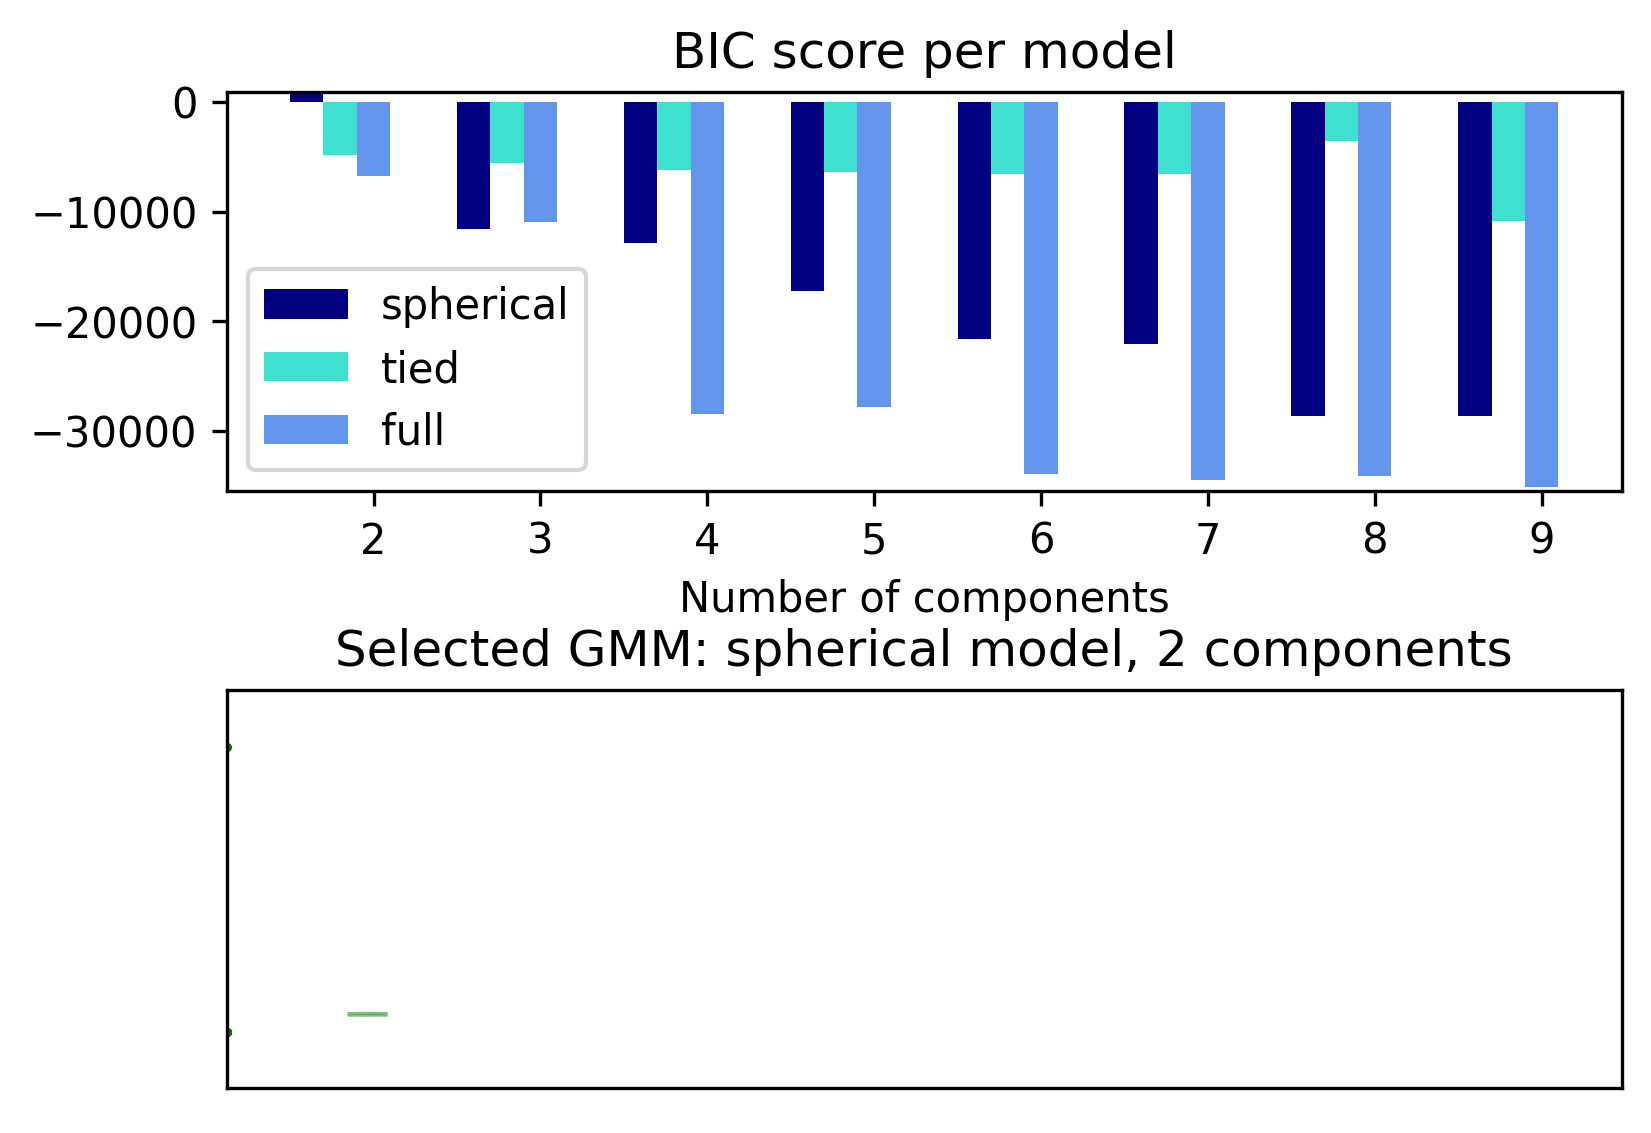

In [84]:
bars = []
spl = plt.subplot(2,1,1)
for i, (cv, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2*(i - 2)
    bars.append(plt.bar(
        xpos, bic[i* len(n_components_range):
        (i+1)* len(n_components_range)],
        width=.2, color=color
    ))
plt.xticks(n_components_range)
plt.ylim([bic.min()*1.01 - 0.01* bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

labels = clf.predict(X)
plot_results(
    X, labels, gmm.means_, gmm.covariances_,
    1, 'Gaussian Mixture-%s' %gmm.converged_
)
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: %s model, %s components'%(best_gmm['name']. split('_')[0], 
                best_gmm['name'].split('_')[1]))
plt.subplots_adjust(hspace=0.5, bottom=0.05)
plt.show()